## Q-Learning agent

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hanoi import Hanoi, Action
np.random.seed(42)

In [2]:
def get_table_value (table, action, state):
  return table[action][state] if state in table[action] else 0

def choose_action(d, table):
  actions = d.get_actions()
  values = list(map(lambda a: get_table_value(table, a, d.state), actions))

  if values.count(values[0])==len(values):
    return Action(np.random.choice(actions))
  else:
    idx_max = max(range(len(values)), key=values.__getitem__)
    return actions[idx_max]

In [3]:
def create_table(nb_actions):
  table = []
  for _ in range(nb_actions):
    table.append({})
  return table

In [4]:
def greedy_fit(nb_iterations=2000):
  d = create_env()
  greedy_table = create_table(env.nb_actions)
  for _ in range(nb_iterations):
    action = choose_action(d, greedy_table)
    old_state = d.state
    d.set_state(d.get_new_state(action))
    reward = d.get_reward()
    greedy_table[action][old_state] = get_table_value(greedy_table, action, old_state) + reward

    if d.is_final_state():
      d = create_env()
  return greedy_table

In [5]:
def choose_q_action(d, q_table, gambling_rate):
  if np.random.random() <= gambling_rate:
    return Action(np.random.choice(d.get_actions()))
  else:
    return choose_action(d, q_table)

def update_q_table(eta, discount, q_table, old_state, d_new, action):
  reward = d_new.get_reward()
  actual_value = get_table_value(q_table, action, old_state)

  max_list = list(map(lambda a: get_table_value(q_table, a, d_new.state), d_new.get_actions()))
  max_value = max(max_list)
  
  return actual_value + eta * (reward + discount * max_value - actual_value)


In [6]:
def Q_fit(nb_iterations=4000):
  d = create_env()
  eta = 0.1
  discount = 0.95
  gambling_rate = 1

  q_table = create_table(env.nb_actions)
  for _ in range(nb_iterations):
    action = choose_q_action(d, q_table, gambling_rate)
    gambling_rate -= 1/nb_iterations
    old_state = d.state
    d.set_state(d.get_new_state(action))
    q_table[action][old_state] = update_q_table(eta, discount, q_table, old_state, d, action)

    if d.is_final_state():
      d = create_env()
  return q_table

In [7]:
def play(policy):
  d = create_env()
  nb_moves = 0
  while d.state != d.final_state and nb_moves < 100:
    action = choose_action(d, policy)
    d.set_state(d.get_new_state(action))
    nb_moves += 1
  return nb_moves

def plot_Q_evolution(it_list, path=None):
  plt.figure(dpi=150)
  nb_optimal_moves = 2**N-1
  nb_moves = []
  for it in it_list:
    tmp = []
    for _ in range(5):
      policy = Q_fit(it)
      tmp.append(play(policy))
    nb_moves.append(np.mean(tmp))
  
  plt.plot(it_list, nb_moves, ".-", color='r', label="Average number of moves found by the agent")
  plt.axhline(nb_optimal_moves, color="orange", label=f"Optimal number of moves = {nb_optimal_moves}")
  plt.xlabel("Number of iterations")
  plt.ylabel("Number of moves")
  plt.title(f"Solving Towers of Hanoï with {N} disks using Q-Learning")
  lgd = plt.legend(bbox_to_anchor=(0.5, -0.3), loc="center")
  if path != None:
    plt.savefig(path, bbox_extra_artists=(lgd,), bbox_inches="tight")


In [8]:
env = Hanoi
N = 3
def create_env():
  return env(N)

In [9]:
#greedy_fit()

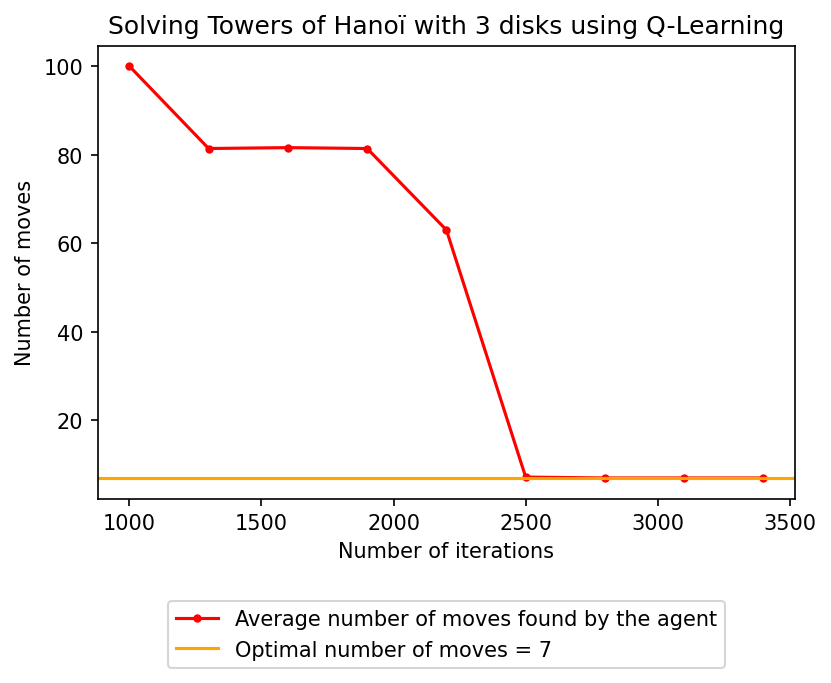

In [10]:
plot_Q_evolution(np.arange(1000, 3500, 300))